In [ ]:
import av  
import cv2
import mediapipe as mp
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

In [1]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2)

container = av.open("2025-07-02 12-39-59.mp4")
stream = container.streams.video[0]
fps = float(stream.average_rate) if stream.average_rate else 30 
print(f"Detected FPS from PyAV: {fps}")

width = stream.codec_context.width
height = stream.codec_context.height
fourcc = cv2.VideoWriter_fourcc(*'avc1')
out = cv2.VideoWriter("2025-07-02 12-39-59_overlay.mov", fourcc, fps, (width, height))

landmark_csv = open("hand_landmarks_04-2.csv", mode="w", newline="")
landmark_writer = csv.writer(landmark_csv)
landmark_writer.writerow(["frame", "time_sec", "hand", "landmark_id", "x", "y", "z", "hand_detected"])

summary_csv = open("frame_detection_summary.csv", mode="w", newline="")
summary_writer = csv.writer(summary_csv)
summary_writer.writerow(["frame", "time_sec", "hands_detected", "hand_labels_detected"])

frame_num = 0
frames_with_detection = 0
total_frames = 0

for frame in container.decode(video=0):
    # PyAV frame -> numpy array (RGB)
    img = frame.to_ndarray(format="bgr24")
    time_sec = float(frame.pts * frame.time_base) if frame.pts else frame_num / fps

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img_rgb)

    detected_labels = []

    if result.multi_hand_landmarks and result.multi_handedness:
        hands_detected = len(result.multi_hand_landmarks)
        frames_with_detection += 1

        for (hand_landmarks, handedness) in zip(result.multi_hand_landmarks, result.multi_handedness):
            hand_label = handedness.classification[0].label  # 'Left' or 'Right'
            detected_labels.append(hand_label)

            for idx, lm in enumerate(hand_landmarks.landmark):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, lm.x, lm.y, lm.z, 1])

            # Draw with different color
            color = (0, 255, 0) if hand_label == "Left" else (0, 0, 255)
            mp_draw.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS,
                mp_draw.DrawingSpec(color=color, thickness=2, circle_radius=3),
                mp_draw.DrawingSpec(color=color, thickness=2)
            )
    else:
        hands_detected = 0
        for hand_label in ['Left', 'Right']:
            for idx in range(21):
                landmark_writer.writerow([frame_num, time_sec, hand_label, idx, None, None, None, 0])

    summary_writer.writerow([frame_num, time_sec, hands_detected, ','.join(detected_labels)])

    out.write(img)

    cv2.imshow("Hand Detection VFR", img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    frame_num += 1
    total_frames += 1

landmark_csv.close()
summary_csv.close()
out.release()
cv2.destroyAllWindows()

print("-------- Detection Report --------")
print(f"Total frames: {total_frames}")
print(f"Frames with at least 1 hand detected: {frames_with_detection}")
print(f"Detection rate: {frames_with_detection/total_frames:.2%}")

I0000 00:00:1752196153.565199 23316618 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1752196153.579615 23317598 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752196153.585020 23317603 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Detected FPS from PyAV: 60.0


W0000 00:00:1752196163.926891 23317604 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


-------- Detection Report --------
Total frames: 5554
Frames with at least 1 hand detected: 4160
Detection rate: 74.90%


In [12]:
df = pd.read_csv("hand_landmarks_04-2.csv")

print("Shape:", df.shape)
df

Shape: (159579, 8)


,frame,time_sec,hand,landmark_id,x,y,z,hand_detected
0,0,0.000000,Left,0,NaN,NaN,NaN,0
1,0,0.000000,Left,1,NaN,NaN,NaN,0
2,0,0.000000,Left,2,NaN,NaN,NaN,0
3,0,0.000000,Left,3,NaN,NaN,NaN,0
4,0,0.000000,Left,4,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
159574,5553,92.566667,Right,16,NaN,NaN,NaN,0
159575,5553,92.566667,Right,17,NaN,NaN,NaN,0
159576,5553,92.566667,Right,18,NaN,NaN,NaN,0
159577,5553,92.566667,Right,19,NaN,NaN,NaN,0


In [15]:
df_wide = df.pivot_table(index=["frame", "time_sec", "hand", "hand_detected"], 
                                columns="landmark_id", 
                                values=["x", "y", "z"])
df_wide.columns = [f"{coord}_{lmk}" for coord, lmk in df_wide.columns]
df_wide = df_wide.reset_index()

In [19]:
df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,130,2.166667,Right,1,0.738505,0.710959,0.698660,0.684178,0.664810,0.724225,...,0.006539,-0.002879,0.009030,0.005693,-0.003078,-0.009335,-0.002649,-0.004179,-0.005935,-0.007309
1,131,2.183333,Right,1,0.737979,0.712257,0.701511,0.691344,0.677483,0.720863,...,0.008173,-0.001038,0.013513,0.009780,0.000729,-0.005026,0.002878,0.001717,0.000171,-0.000643
2,132,2.200000,Left,1,0.710900,0.712863,0.710496,0.698376,0.683844,0.716012,...,-0.021875,-0.028722,0.000443,-0.006392,-0.013666,-0.018596,0.005161,-0.000662,-0.005437,-0.008684
3,133,2.216667,Left,1,0.708774,0.687759,0.670601,0.650175,0.635775,0.705444,...,-0.016742,-0.023901,0.004722,-0.000229,-0.006974,-0.011202,0.006689,0.002563,-0.000764,-0.002241
4,133,2.216667,Right,1,0.710800,0.705713,0.696593,0.680581,0.665413,0.706511,...,-0.042099,-0.048901,-0.021511,-0.034084,-0.040755,-0.044970,-0.023458,-0.034412,-0.039647,-0.043106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,5242,87.366667,Left,1,0.477884,0.432659,0.399883,0.380050,0.368171,0.443997,...,-0.073737,-0.077345,-0.041500,-0.059412,-0.067250,-0.070569,-0.036263,-0.051164,-0.057548,-0.060155
4650,5243,87.383333,Left,1,0.473246,0.426719,0.392315,0.376288,0.366483,0.443123,...,-0.092380,-0.094676,-0.055528,-0.076649,-0.081553,-0.082250,-0.049741,-0.065671,-0.069324,-0.069729
4651,5244,87.400000,Left,1,0.475246,0.426368,0.392347,0.378442,0.372102,0.445767,...,-0.093411,-0.095382,-0.055018,-0.077076,-0.082413,-0.082911,-0.048457,-0.065100,-0.069318,-0.069828
4652,5245,87.416667,Right,1,0.467694,0.476949,0.468619,0.449387,0.426027,0.478981,...,-0.023768,-0.028451,-0.026375,-0.032147,-0.037126,-0.042133,-0.037866,-0.044936,-0.047556,-0.049820


In [22]:
df_wide['time_sec'] = df_wide['time_sec'].round(3)

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_11,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20
0,130,2.167,Right,1,0.738505,0.710959,0.698660,0.684178,0.664810,0.724225,...,0.006539,-0.002879,0.009030,0.005693,-0.003078,-0.009335,-0.002649,-0.004179,-0.005935,-0.007309
1,131,2.183,Right,1,0.737979,0.712257,0.701511,0.691344,0.677483,0.720863,...,0.008173,-0.001038,0.013513,0.009780,0.000729,-0.005026,0.002878,0.001717,0.000171,-0.000643
2,132,2.200,Left,1,0.710900,0.712863,0.710496,0.698376,0.683844,0.716012,...,-0.021875,-0.028722,0.000443,-0.006392,-0.013666,-0.018596,0.005161,-0.000662,-0.005437,-0.008684
3,133,2.217,Left,1,0.708774,0.687759,0.670601,0.650175,0.635775,0.705444,...,-0.016742,-0.023901,0.004722,-0.000229,-0.006974,-0.011202,0.006689,0.002563,-0.000764,-0.002241
4,133,2.217,Right,1,0.710800,0.705713,0.696593,0.680581,0.665413,0.706511,...,-0.042099,-0.048901,-0.021511,-0.034084,-0.040755,-0.044970,-0.023458,-0.034412,-0.039647,-0.043106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,5242,87.367,Left,1,0.477884,0.432659,0.399883,0.380050,0.368171,0.443997,...,-0.073737,-0.077345,-0.041500,-0.059412,-0.067250,-0.070569,-0.036263,-0.051164,-0.057548,-0.060155
4650,5243,87.383,Left,1,0.473246,0.426719,0.392315,0.376288,0.366483,0.443123,...,-0.092380,-0.094676,-0.055528,-0.076649,-0.081553,-0.082250,-0.049741,-0.065671,-0.069324,-0.069729
4651,5244,87.400,Left,1,0.475246,0.426368,0.392347,0.378442,0.372102,0.445767,...,-0.093411,-0.095382,-0.055018,-0.077076,-0.082413,-0.082911,-0.048457,-0.065100,-0.069318,-0.069828
4652,5245,87.417,Right,1,0.467694,0.476949,0.468619,0.449387,0.426027,0.478981,...,-0.023768,-0.028451,-0.026375,-0.032147,-0.037126,-0.042133,-0.037866,-0.044936,-0.047556,-0.049820


In [30]:
df2 = pd.read_csv("hand_lable_04-2.csv")

print("Shape:", df.shape)
df2

Shape: (159579, 8)


,Observation id,Observation date,Description,Observation duration,Observation type,Source,Time offset (s),Media duration (s),FPS,Subject,Behavior,Behavioral category,Behavior type,Time,Media file name,Image index,Image file path,Comment
0,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,other,NaN,START,5.133,D:/Data Science/UOB/DS_project/Full Study/04-2...,308,NaN,NaN
1,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,other,NaN,STOP,5.467,D:/Data Science/UOB/DS_project/Full Study/04-2...,328,NaN,NaN
2,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,lift,NaN,START,5.483,D:/Data Science/UOB/DS_project/Full Study/04-2...,329,NaN,NaN
3,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,lift,NaN,STOP,6.500,D:/Data Science/UOB/DS_project/Full Study/04-2...,390,NaN,NaN
4,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,hold,NaN,START,6.517,D:/Data Science/UOB/DS_project/Full Study/04-2...,391,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,hold,NaN,STOP,82.950,D:/Data Science/UOB/DS_project/Full Study/04-2...,4977,NaN,NaN
74,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,place,NaN,START,82.967,D:/Data Science/UOB/DS_project/Full Study/04-2...,4978,NaN,NaN
75,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,place,NaN,STOP,85.950,D:/Data Science/UOB/DS_project/Full Study/04-2...,5157,NaN,NaN
76,04-2,2025-07-08 18:13:06.613,NaN,82.667,Media file(s),player #1:D:/Data Science/UOB/DS_project/Full ...,0.0,92.567,60.0,NaN,other,NaN,START,85.967,D:/Data Science/UOB/DS_project/Full Study/04-2...,5158,NaN,NaN


In [33]:
df_sub = df2[['Behavior', 'Behavior type', 'Time', 'Image index']]

df_start = df_sub[df_sub['Behavior type'] == 'START'].copy()
df_stop  = df_sub[df_sub['Behavior type'] == 'STOP'].copy()

df_start = df_start.reset_index(drop=True)
df_stop  = df_stop.reset_index(drop=True)

df_events = pd.DataFrame({
    'behavior': df_start['Behavior'],
    'start_time': df_start['Time'],
    'stop_time': df_stop['Time'],
    'start_image_index': df_start['Image index'],
    'stop_image_index': df_stop['Image index']
})

df_events

,behavior,start_time,stop_time,start_image_index,stop_image_index
0,other,5.133,5.467,308,328
1,lift,5.483,6.500,329,390
2,hold,6.517,12.850,391,771
3,press,12.867,13.783,772,827
4,hold,13.800,14.283,828,857
5,press,14.300,15.533,858,932
6,adjust,15.550,23.467,933,1408
7,hold,23.483,26.833,1409,1610
8,place,26.850,27.733,1611,1664
9,lift,27.750,28.483,1665,1709


In [36]:
df_wide['behavior'] = np.nan

for _, row in df_events.iterrows():
    b = row['behavior']
    t_start = row['start_time']
    t_stop = row['stop_time']

    mask = (df_wide['time_sec'] >= t_start) & (df_wide['time_sec'] <= t_stop)

    df_wide.loc[mask, 'behavior'] = b

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_9230/1143471531.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'other' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_wide.loc[mask, 'behavior'] = b


,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
0,130,2.167,Right,1,0.738505,0.710959,0.698660,0.684178,0.664810,0.724225,...,-0.002879,0.009030,0.005693,-0.003078,-0.009335,-0.002649,-0.004179,-0.005935,-0.007309,NaN
1,131,2.183,Right,1,0.737979,0.712257,0.701511,0.691344,0.677483,0.720863,...,-0.001038,0.013513,0.009780,0.000729,-0.005026,0.002878,0.001717,0.000171,-0.000643,NaN
2,132,2.200,Left,1,0.710900,0.712863,0.710496,0.698376,0.683844,0.716012,...,-0.028722,0.000443,-0.006392,-0.013666,-0.018596,0.005161,-0.000662,-0.005437,-0.008684,NaN
3,133,2.217,Left,1,0.708774,0.687759,0.670601,0.650175,0.635775,0.705444,...,-0.023901,0.004722,-0.000229,-0.006974,-0.011202,0.006689,0.002563,-0.000764,-0.002241,NaN
4,133,2.217,Right,1,0.710800,0.705713,0.696593,0.680581,0.665413,0.706511,...,-0.048901,-0.021511,-0.034084,-0.040755,-0.044970,-0.023458,-0.034412,-0.039647,-0.043106,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,5242,87.367,Left,1,0.477884,0.432659,0.399883,0.380050,0.368171,0.443997,...,-0.077345,-0.041500,-0.059412,-0.067250,-0.070569,-0.036263,-0.051164,-0.057548,-0.060155,other
4650,5243,87.383,Left,1,0.473246,0.426719,0.392315,0.376288,0.366483,0.443123,...,-0.094676,-0.055528,-0.076649,-0.081553,-0.082250,-0.049741,-0.065671,-0.069324,-0.069729,other
4651,5244,87.400,Left,1,0.475246,0.426368,0.392347,0.378442,0.372102,0.445767,...,-0.095382,-0.055018,-0.077076,-0.082413,-0.082911,-0.048457,-0.065100,-0.069318,-0.069828,other
4652,5245,87.417,Right,1,0.467694,0.476949,0.468619,0.449387,0.426027,0.478981,...,-0.028451,-0.026375,-0.032147,-0.037126,-0.042133,-0.037866,-0.044936,-0.047556,-0.049820,other


In [39]:
print(df_wide['behavior'].value_counts(dropna=False))

behavior
hold      1155
rotate    1102
adjust    1051
press      557
place      271
lift       194
NaN        186
other      138
Name: count, dtype: int64


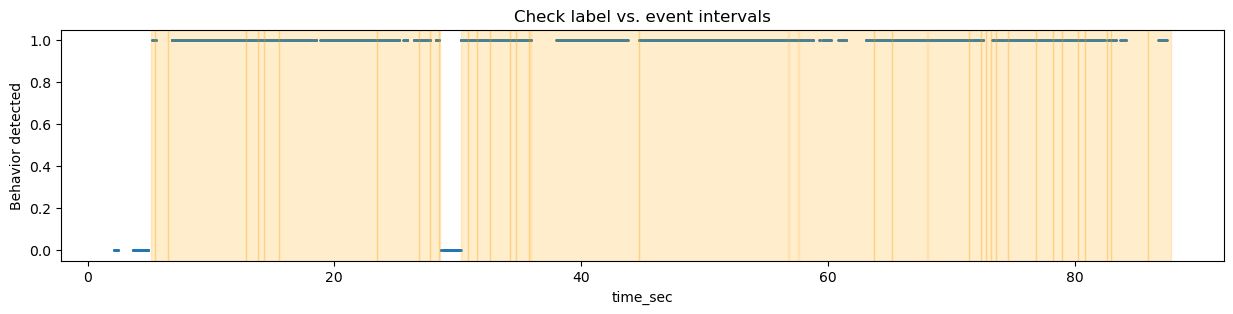

In [42]:
plt.figure(figsize=(15, 3))
plt.scatter(df_wide['time_sec'], df_wide['behavior'].notna(), s=1)
for _, row in df_events.iterrows():
    plt.axvspan(row['start_time'], row['stop_time'], color='orange', alpha=0.2)

plt.xlabel("time_sec")
plt.ylabel("Behavior detected")
plt.title("Check label vs. event intervals")
plt.show()

In [45]:
df_clean = df_wide.dropna(subset=['behavior'])

df_wide = df_clean

df_wide

,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,x_5,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
99,314,5.233,Left,1,0.571471,0.542681,0.531212,0.516338,0.500559,0.604929,...,0.056882,0.038128,0.056563,0.062792,0.065823,0.058962,0.071576,0.076811,0.081129,other
100,315,5.250,Left,1,0.572715,0.547506,0.538135,0.527285,0.515786,0.611346,...,0.077022,0.050201,0.072583,0.082469,0.088030,0.071617,0.087546,0.094689,0.100369,other
101,316,5.267,Left,1,0.573961,0.548149,0.537520,0.526633,0.514240,0.610965,...,0.073451,0.047489,0.068940,0.079632,0.086107,0.067886,0.083828,0.091984,0.098636,other
102,317,5.283,Left,1,0.571666,0.546042,0.537179,0.528945,0.518923,0.606441,...,0.051595,0.038701,0.056423,0.058634,0.057189,0.058090,0.069591,0.071474,0.072031,other
103,318,5.300,Left,1,0.571471,0.546566,0.537506,0.528920,0.518257,0.606807,...,0.049945,0.037066,0.054213,0.057473,0.057009,0.056246,0.067407,0.069842,0.071061,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,5242,87.367,Left,1,0.477884,0.432659,0.399883,0.380050,0.368171,0.443997,...,-0.077345,-0.041500,-0.059412,-0.067250,-0.070569,-0.036263,-0.051164,-0.057548,-0.060155,other
4650,5243,87.383,Left,1,0.473246,0.426719,0.392315,0.376288,0.366483,0.443123,...,-0.094676,-0.055528,-0.076649,-0.081553,-0.082250,-0.049741,-0.065671,-0.069324,-0.069729,other
4651,5244,87.400,Left,1,0.475246,0.426368,0.392347,0.378442,0.372102,0.445767,...,-0.095382,-0.055018,-0.077076,-0.082413,-0.082911,-0.048457,-0.065100,-0.069318,-0.069828,other
4652,5245,87.417,Right,1,0.467694,0.476949,0.468619,0.449387,0.426027,0.478981,...,-0.028451,-0.026375,-0.032147,-0.037126,-0.042133,-0.037866,-0.044936,-0.047556,-0.049820,other


In [48]:
df_wide['dataset_id'] = '0402'

cols = df_wide.columns.tolist()
cols = ['dataset_id'] + [col for col in cols if col != 'dataset_id']
df_wide = df_wide[cols]

df_wide

/var/folders/rj/522y7b7n1dl67qg86lzg9y_00000gn/T/ipykernel_9230/3995059342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_wide['dataset_id'] = '0402'


,dataset_id,frame,time_sec,hand,hand_detected,x_0,x_1,x_2,x_3,x_4,...,z_12,z_13,z_14,z_15,z_16,z_17,z_18,z_19,z_20,behavior
99,0402,314,5.233,Left,1,0.571471,0.542681,0.531212,0.516338,0.500559,...,0.056882,0.038128,0.056563,0.062792,0.065823,0.058962,0.071576,0.076811,0.081129,other
100,0402,315,5.250,Left,1,0.572715,0.547506,0.538135,0.527285,0.515786,...,0.077022,0.050201,0.072583,0.082469,0.088030,0.071617,0.087546,0.094689,0.100369,other
101,0402,316,5.267,Left,1,0.573961,0.548149,0.537520,0.526633,0.514240,...,0.073451,0.047489,0.068940,0.079632,0.086107,0.067886,0.083828,0.091984,0.098636,other
102,0402,317,5.283,Left,1,0.571666,0.546042,0.537179,0.528945,0.518923,...,0.051595,0.038701,0.056423,0.058634,0.057189,0.058090,0.069591,0.071474,0.072031,other
103,0402,318,5.300,Left,1,0.571471,0.546566,0.537506,0.528920,0.518257,...,0.049945,0.037066,0.054213,0.057473,0.057009,0.056246,0.067407,0.069842,0.071061,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649,0402,5242,87.367,Left,1,0.477884,0.432659,0.399883,0.380050,0.368171,...,-0.077345,-0.041500,-0.059412,-0.067250,-0.070569,-0.036263,-0.051164,-0.057548,-0.060155,other
4650,0402,5243,87.383,Left,1,0.473246,0.426719,0.392315,0.376288,0.366483,...,-0.094676,-0.055528,-0.076649,-0.081553,-0.082250,-0.049741,-0.065671,-0.069324,-0.069729,other
4651,0402,5244,87.400,Left,1,0.475246,0.426368,0.392347,0.378442,0.372102,...,-0.095382,-0.055018,-0.077076,-0.082413,-0.082911,-0.048457,-0.065100,-0.069318,-0.069828,other
4652,0402,5245,87.417,Right,1,0.467694,0.476949,0.468619,0.449387,0.426027,...,-0.028451,-0.026375,-0.032147,-0.037126,-0.042133,-0.037866,-0.044936,-0.047556,-0.049820,other


In [51]:
df_wide.to_csv("handlandmark_wide_04-2.csv", index=False)